## Import all Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('vader_lexicon')
import nltk.corpus
import os
import sys
import json
from collections import Counter
import swifter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
from ipywidgets import FloatProgress
from tqdm import tqdm
import pandas as pd

In [2]:
# %pip install transformers

## Load the Dataset and Perform VADER Sentiment Analysis
The sentiment analysis is performed on review Text 

In [3]:
import pandas as pd
from transformers import pipeline
from datasets import Dataset
from tqdm.auto import tqdm

# Load data in chunks to avoid MemoryError
filename = "Magazine_Subscriptions"
filepath = "Datasets/" + filename + ".json"

chunks = []
for chunk in pd.read_json(filepath, lines=True, chunksize=10000):
    chunks.append(chunk)

df_raw = pd.concat(chunks, ignore_index=True)

# Load BERT sentiment analysis model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    truncation=True,
    device=0  # Use GPU
)

# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df_raw[['reviewText']])

# Batched sentiment analysis using Dataset.map()
def get_sentiment(batch):
    texts = [str(t)[:512] for t in batch['reviewText']]
    results = sentiment_pipeline(texts, batch_size=32)
    return {"sentiment": [int(res['label'].split()[0]) for res in results]}

tqdm.pandas()
dataset = dataset.map(get_sentiment, batched=True, batch_size=32)

# Add sentiment back to DataFrame
df_raw['sentiment'] = dataset['sentiment']

# Compute ratings
count = len(df_raw)
avg_rating = df_raw['sentiment'].mean() if count > 0 else 0
comp_rating = ((df_raw['overall'] + df_raw['sentiment']) / 2).mean() if count > 0 else 0

# Save to CSV
output_path = "output/" + filename + ".csv"
df_raw.to_csv(output_path, index=False)

# Reload and process time column
df_raw = pd.read_csv(output_path)
df_raw['reviewTime'] = pd.to_datetime(df_raw['unixReviewTime'], unit='s')

df_raw.head()


Device set to use cuda:0


Map:   0%|          | 0/89689 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
C:\Users\SUBHASHIS\AppData\Local\Temp\ipykernel_8356\1127928227.py:49: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(output_path)


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,sentiment
0,5,9.0,False,2001-11-08,AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN,4
1,5,9.0,False,2001-10-31,AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN,1
2,3,14.0,False,2007-03-24,A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN,2
3,5,13.0,False,2006-11-10,A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN,5
4,5,NaN,True,2014-07-14,A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN,5


## Group the data in 7 days

In [4]:

df_grouped = df_raw.groupby(pd.Grouper(key='reviewTime', freq='7D')).agg(
    review_count=('reviewerID', 'count'),
    average_sentiment=('sentiment', 'mean'),
    average_rating=('overall', 'mean'),
    helpfulness=('vote','count')
).reset_index()

In [5]:
df_grouped=df_grouped.fillna(0)
df_grouped.set_index('reviewTime', inplace=True)
df_grouped.head()

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2001-10-26,134,4.156716,4.373134,103
2001-11-02,27,4.370370,4.555556,24
2001-11-09,14,4.071429,4.428571,14
2001-11-16,17,3.705882,4.411765,16
2001-11-23,26,4.038462,4.153846,24


In [6]:
# See average sentiment
print(df_grouped['average_sentiment'].min(),df_grouped['average_sentiment'].max())
min_sentiment=df_grouped['average_sentiment'].min()
max_sentiment=df_grouped['average_sentiment'].max()


df_grouped['average_sentiment']=1+(df_grouped['average_sentiment']-min_sentiment)*(5-1)/(max_sentiment-min_sentiment)

max_value = df_grouped['helpfulness'].max()
min_value = df_grouped['helpfulness'].min()

df_grouped['helpfulness']=1+ (df_grouped['helpfulness']-min_value)*(4)/(max_value-min_value)
df_grouped['mixture']=df_grouped['helpfulness']*df_grouped['average_sentiment']*df_grouped['average_rating']
df_grouped['mixture']=1+ (df_grouped['mixture']-min_value)*(4)/(max_value-min_value)


max_value = df_grouped['review_count'].max()
min_value = df_grouped['review_count'].min()

print(min_value,max_value)
df_grouped['review_count']=1+ (df_grouped['review_count']-min_value)*(4)/(max_value-min_value)

1.9285714285714286 5.0
2 528


In [7]:
df_grouped.head()

,review_count,average_sentiment,average_rating,helpfulness,mixture
reviewTime,,,,,
2001-10-26,2.003802,3.901770,4.373134,5.000000,4.313197
2001-11-02,1.190114,4.180017,4.555556,1.932039,2.428756
2001-11-09,1.091255,3.790698,4.428571,1.543689,2.006388
2001-11-16,1.114068,3.314637,4.411765,1.621359,1.920768
2001-11-23,1.182510,3.747764,4.153846,1.932039,2.168049


## Use RandomForestRegressor to determine the most important features

             Feature  Importance
3            mixture    0.758813
0  average_sentiment    0.097808
1     average_rating    0.078185
2        helpfulness    0.065194


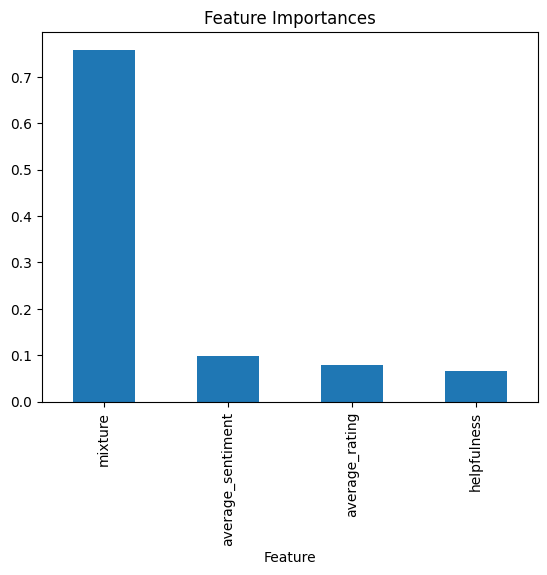

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming df_grouped is your DataFrame and 'review_count' is your target
X = df_grouped[['average_sentiment', 'average_rating', 'helpfulness', 'mixture']]
y = df_grouped['review_count']

# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)

#Plot the feature importances
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, title="Feature Importances")
plt.show()


In [9]:
feature_importance = dict(zip(importance_df['Feature'], importance_df['Importance']))

# Normalize the feature importance to sum to 1
total_importance = sum(feature_importance.values())

In [10]:
normalized_importance = {key: value / total_importance for key, value in feature_importance.items()}

# Scaling the relevant columns based on the normalized feature importance
df_scaled = df_grouped.copy()
df_scaled['helpfulness'] *= normalized_importance['helpfulness']
df_scaled['average_rating'] *= normalized_importance['average_rating']
df_scaled['average_sentiment'] *= normalized_importance['average_sentiment']

In [11]:
#  split train/valid/test
n = len(df_grouped)
train_end = int(n * 0.7)
val_end = n - int(n * 0.1)
test_end = n

seq_len=16
pred_len=60
batch_size=60

df_grouped_bak=df_grouped

df_grouped_bak['review_count'] = np.log(df_grouped_bak['review_count']+1)

log_min = df_grouped_bak['review_count'].min()
log_max = df_grouped_bak['review_count'].max()


df_grouped_bak=df_grouped_bak/10


In [12]:
train_df = df_grouped_bak[:train_end]
val_df = df_grouped_bak[train_end - seq_len: val_end]
test_df = df_grouped_bak[val_end - seq_len: test_end]

In [13]:
def _split_window(data,target_slice=slice(0,None)):
    inputs = data[:, : seq_len, :]
    labels = data[:, seq_len :, target_slice]
    inputs.set_shape([None, seq_len, None])
    labels.set_shape([None, pred_len, None])
    return inputs, labels

def _make_dataset(data, shuffle=True, targets=None):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=(seq_len + pred_len),
        sequence_stride=5,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    ds = ds.map(_split_window)
    return ds

def get_train(self, shuffle=True):
    return self._make_dataset(self.train_df, shuffle=shuffle)


In [14]:
import tensorflow as tf
train_data  =   _make_dataset(train_df, shuffle=False)
val_data    =   _make_dataset(val_df, shuffle=False)
test_data   =   _make_dataset(test_df, shuffle=False)

In [15]:
from tensorflow.keras import layers

def res_block(inputs, ff_dim):

  norm = layers.LayerNormalization

  # Time mixing
  x = norm(axis=[-2, -1])(inputs)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(x.shape[-1], activation='relu')(x)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  res = x + inputs

  # Feature mixing
  x = norm(axis=[-2, -1])(res)
  x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
  x = layers.Dropout(0.6)(x)
  x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  return (x + res ) #* (avg_rating/5.0) * (comp_rating/5.0)

def build_model(
    input_shape,
    pred_len,
    n_block,
    ff_dim,
    target_slice,
):

  inputs = tf.keras.Input(shape=input_shape)
  x = inputs  # [Batch, Input Length, Channel]
  for _ in range(n_block):
    x = res_block(x, ff_dim)

  if target_slice:
    x = x[:, :, target_slice]

  # Temporal projection
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
  outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

  return tf.keras.Model(inputs, outputs)


n_feature = train_df.shape[-1]
model = build_model(
    input_shape=(seq_len, n_feature),
    pred_len=pred_len,
    n_block=16,
    ff_dim=64,
    target_slice=slice(0,None)
)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
tf.keras.utils.set_random_seed(7)

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=24,
    decay_rate=0.97,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer, loss='mse', metrics=['mse'])
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',           
    monitor='val_mse',        
    save_best_only=True,       # Save only the best model (lowest val_loss)
    mode='min',                
    verbose=1,
)


In [17]:
history = model.fit(
    train_data,
    epochs= 1000,
    validation_data=test_data,
    callbacks=[checkpoint_callback]
)

Epoch 1/1000
2/2 [==============================] - ETA: 0s - loss: 137.3736 - mse: 137.3736
Epoch 1: val_mse improved from inf to 1.47808, saving model to best_model.h5
2/2 [==============================] - 12s 3s/step - loss: 137.3736 - mse: 137.3736 - val_loss: 1.4781 - val_mse: 1.4781
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 39.7375 - mse: 39.7375
Epoch 2: val_mse did not improve from 1.47808
2/2 [==============================] - 0s 133ms/step - loss: 39.7375 - mse: 39.7375 - val_loss: 35.3879 - val_mse: 35.3879
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 50.9035 - mse: 50.9035
Epoch 3: val_mse did not improve from 1.47808
2/2 [==============================] - 0s 130ms/step - loss: 50.9035 - mse: 50.9035 - val_loss: 2.1407 - val_mse: 2.1407
Epoch 4/1000
2/2 [==============================] - ETA: 0s - loss: 8.4123 - mse: 8.4123
Epoch 4: val_mse did not improve from 1.47808
2/2 [==============================] - 0s 133ms/step - l

In [18]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')
predictions = model.predict(test_data)

scaled_preds = predictions[-1,:,:]

scaled_preds.shape

cols = ['review_count','average_sentiment','average_rating','helpfulness','mixture']
scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols



1/1 [==============================] - 2s 2s/step


average_sentiment
average_rating
helpfulness
mixture


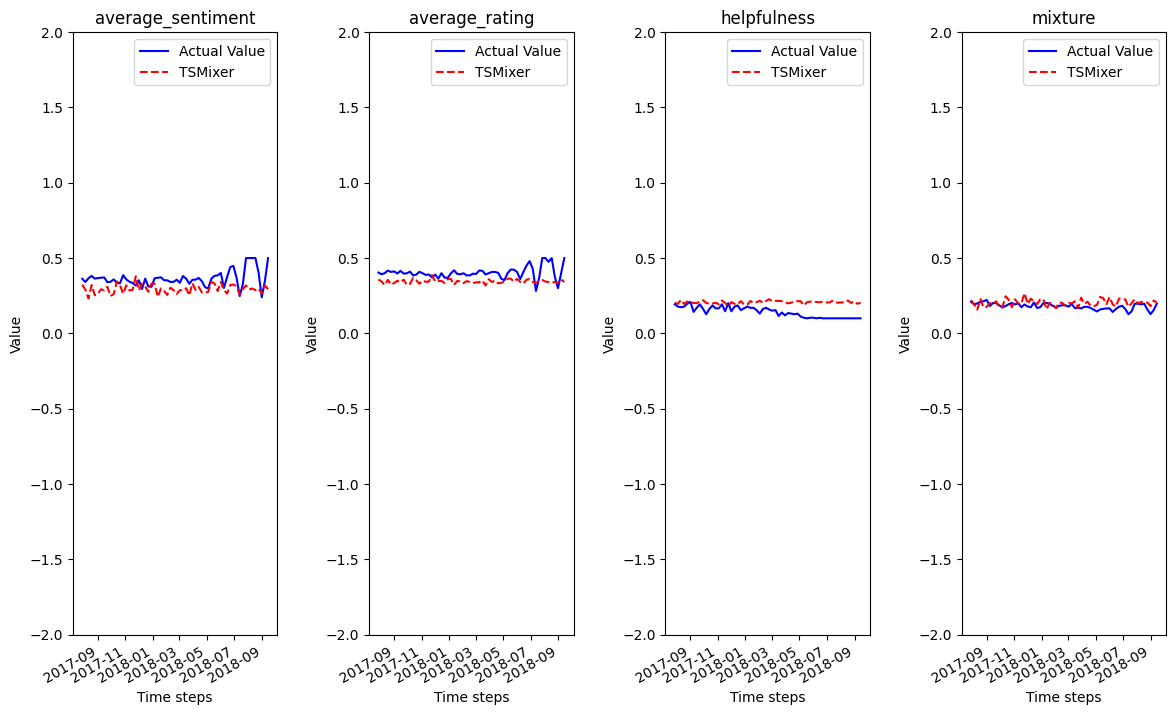

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,8))

for i, ax in enumerate(axes.flatten()[0:4]):
    col = cols[i+1]
    print(col)
    ax.plot(df_grouped.index[-pred_len:], df_grouped_bak[col][-pred_len:], label = 'Actual Value', color='blue')
    ax.plot(df_grouped.index[-pred_len:], scaled_preds_df[col], label='TSMixer', ls='--', color='red')
    
    ax.legend(loc='best')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.set_ylim(-2, 2) 
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

plt.savefig('RESULT_BERT_SENTIMENT_'+filename+'.jpg')

In [20]:
for column in cols[1:5]:
    mse = ((df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) ** 2).mean()
    print('MSE('+column+')='+str(round(mse*100,5))+'%')

MSE(average_sentiment)=0.81142%
MSE(average_rating)=0.5085%
MSE(helpfulness)=0.55264%
MSE(mixture)=0.14682%


In [21]:
actual_values = df_grouped_bak[column][-pred_len:].values
for column in cols[1:5]:
    msle = ((np.log1p(df_grouped_bak[column][-pred_len:].values) - np.log1p(scaled_preds_df[column].values)) ** 2).mean()
    print('MSLE('+column+')='+str(round(msle*100,5))+'%')

MSLE(average_sentiment)=0.44302%
MSLE(average_rating)=0.26288%
MSLE(helpfulness)=0.41025%
MSLE(mixture)=0.10302%


In [22]:
for column in cols[1:5]:
    mape= (abs((df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) / df_grouped_bak[column][-pred_len:].values)).mean() * 100
    print('MAPE('+column+')='+str(round(mape,5))+'%')
    

MAPE(average_sentiment)=19.37082%
MAPE(average_rating)=14.80719%
MAPE(helpfulness)=55.27685%
MAPE(mixture)=18.10074%
